In [1]:
import simi

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sentence_transformers import evaluation, losses, models, InputExample, SentenceTransformer, util as stu
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import torch
from tqdm.auto import tqdm, trange
tqdm.pandas()

RANDOM_STATE = 1

random.seed(RANDOM_STATE)

2023-12-18 14:32:00.035526: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
%%time
df = pd.read_pickle("arxiv-title-embeddings-single-class-multi.pkl")
df.sample(5)

CPU times: user 17.2 s, sys: 10.3 s, total: 27.5 s
Wall time: 27.5 s


,title,categories,embedding (Bert+MP),embedding (Bert+MP+class-arx),embedding (Bert+MP+class-zbm),embedding (Mathbert+CLS),embedding (Mathbert+MP+class-arx),embedding (Mathbert+MP+class-zbm),embedding (Bert+TSDAE+MP),embedding (Bert+TSDAE+MP+class-arx),...,embedding (SBert+ret_class-arx),embedding (SBert+ret_class-zbm),embedding (Specter 2+MP),embedding (Specter 2.0+MP+class-arx),embedding (Specter 2.0+MP+class-zbm),embedding (Specter 2+MP+class-zbm+anch-arx),embedding (Specter 2+MP+anch-arx+class-arx+class-zbm),embedding (SGPT),embedding (SGPT+class-arx),embedding (SGPT+class-zbm)
134867,Stratification of moduli spaces of Lie algebra...,"(math.RA,)","[0.1892751, -0.30268216, -0.14193237, -0.21039...","[0.5779636, -0.39315134, 0.1147531, 0.61886406...","[0.67004657, -0.34884375, 0.5901058, 0.4564445...","[-0.034023166, 0.013464374, -0.0151881995, 0.0...","[0.10203814, 0.8242469, 0.47239465, 1.0014786,...","[-0.3529771, -1.1740661, 0.58534265, 0.5696922...","[0.36230746, 0.008389155, 0.022429505, -0.2182...","[-1.2826664, -0.52481216, 0.9881075, -0.054762...",...,"[0.005430073, 0.008222045, -0.020997057, 0.017...","[-0.01981459, 0.0075035873, -0.03784089, -0.00...","[0.07558761, 0.39270318, 0.7003304, 0.31491986...","[-0.19620037, 1.2360079, 0.51821786, 0.0169042...","[0.33538634, 0.036285456, 1.1480483, -0.390688...","[-0.5712728, -0.47591993, 0.10532383, 0.254386...","[0.29255515, -0.41842678, -0.31737587, 0.22197...","[-0.1397246, -1.2557855, -0.6484578, -0.492025...","[-0.8892877, -0.028096365, 0.48410913, 1.60950...","[-0.4869132, -0.8718603, -0.30802783, 0.482816..."
57725,On the Convergence of Adaptive Sequential Mont...,"(stat.CO,)","[-0.48318464, -0.22661637, -0.32712352, -0.162...","[-0.074153155, -0.097358346, -0.92014354, -0.1...","[0.016437175, 0.19523472, -0.8279452, -0.30003...","[-0.016366104, 0.012063074, -0.018661734, 0.00...","[0.3767771, -0.4029907, -0.54907244, 0.9616571...","[-0.9610342, 0.084142715, 0.16441227, 0.519771...","[0.022206062, 0.1818234, -0.33890706, 0.111219...","[-0.19588858, -0.5976371, 0.2652547, -0.513732...",...,"[0.019717041, -0.05889466, 0.020690361, 0.0059...","[-0.0048485533, -0.019295407, 0.015923077, -0....","[0.41979772, -0.13719064, 0.49092972, 0.007431...","[0.118167736, -0.46496707, 0.44057655, 0.39794...","[0.5550702, -0.44778624, -0.08712787, -0.12993...","[-1.2316751, 0.015822517, 0.52483326, -0.43517...","[-0.5214531, -0.5710844, 0.5621813, -0.5229517...","[-0.05602657, -0.016852451, -0.19599068, -0.97...","[1.6462476, -0.94131273, -0.6112294, -0.475702...","[1.1744641, -0.38795868, -0.41114557, -0.08984..."
80078,Ambiguities in a Problem in Planar Geodesy,"(math.AG,)","[-0.6047793, -0.30516052, 0.030337716, -0.2163...","[-0.59384835, -0.5091851, 1.4711094, 0.4896778...","[-0.69982326, 0.5621379, 1.1482844, -0.3556071...","[-0.03879907, 0.009087635, -0.016315993, -0.00...","[0.32873666, 0.930392, 0.14489704, -0.03116533...","[0.79730064, -0.6697727, -0.76759213, 0.623757...","[-0.094275124, -0.2588583, 0.08343312, -0.0797...","[-0.9329987, -0.4852304, 1.1404178, -0.0461188...",...,"[0.081360444, -0.030461732, 0.015205658, 0.037...","[0.02743353, -0.029915536, -0.030871209, -0.00...","[0.60297203, 1.0347384, 0.56391627, -0.2034236...","[0.26035687, 0.35354918, 1.9683087, 1.3923463,...","[0.9329596, -0.1207464, -0.41019097, -0.759104...","[0.3372948, -0.3920787, 0.2806473, -0.6462991,...","[-0.11925418, 1.2933934, 0.4476275, -0.3866416...","[0.3639918, 0.042286873, -0.14997675, -0.92517...","[-1.4728229, -2.1377969, -0.016991101, -0.2545...","[-0.2893658, -0.14328581, -0.20550443, 0.42429..."
219977,$F$-factors in Quasi-random Hypergraphs,"(math.CO,)","[0.18726, -0.30524975, 0.25433043, -0.03265298...","[1.1993648, 1.4610587, -0.41916946, -0.1855461...","[0.42781624, 0.100528866, -0.33756077, -0.1734...","[-0.022212306, 0.024710199, -0.01961282, -0.01...","[-0.23808731, 0.6592599, -0.618271, -0.0383751...","[-0.39993477, 0.2988955, -0.4853671, -0.176225...","[0.18044451, -0.0

In [3]:
# we only want the primary category
df["categories"] = df["categories"].map(lambda c: c[0])

X_train, X_test_eval, _, __ = train_test_split(df, df["categories"], train_size=0.8, random_state=RANDOM_STATE, stratify=df["categories"])
X_train = X_train.reset_index(drop=True)

X_test, X_eval, _, __ = train_test_split(X_test_eval, X_test_eval["categories"], train_size=0.5, random_state=RANDOM_STATE, stratify=X_test_eval["categories"])
X_test = X_test.reset_index(drop=True)
X_eval = X_eval.reset_index(drop=True)

print("train:", len(X_train), "test:", len(X_test), "eval:", len(X_eval))

train: 217833 test: 27229 eval: 27230


In [4]:
mark_distrib = pd.DataFrame(X_train["categories"].value_counts(normalize=True).reset_index()).merge(
        pd.DataFrame(X_test["categories"].value_counts(normalize=True)).reset_index(), on="index").merge(
        pd.DataFrame(X_eval["categories"].value_counts(normalize=True)).reset_index(), on="index")

<AxesSubplot:>

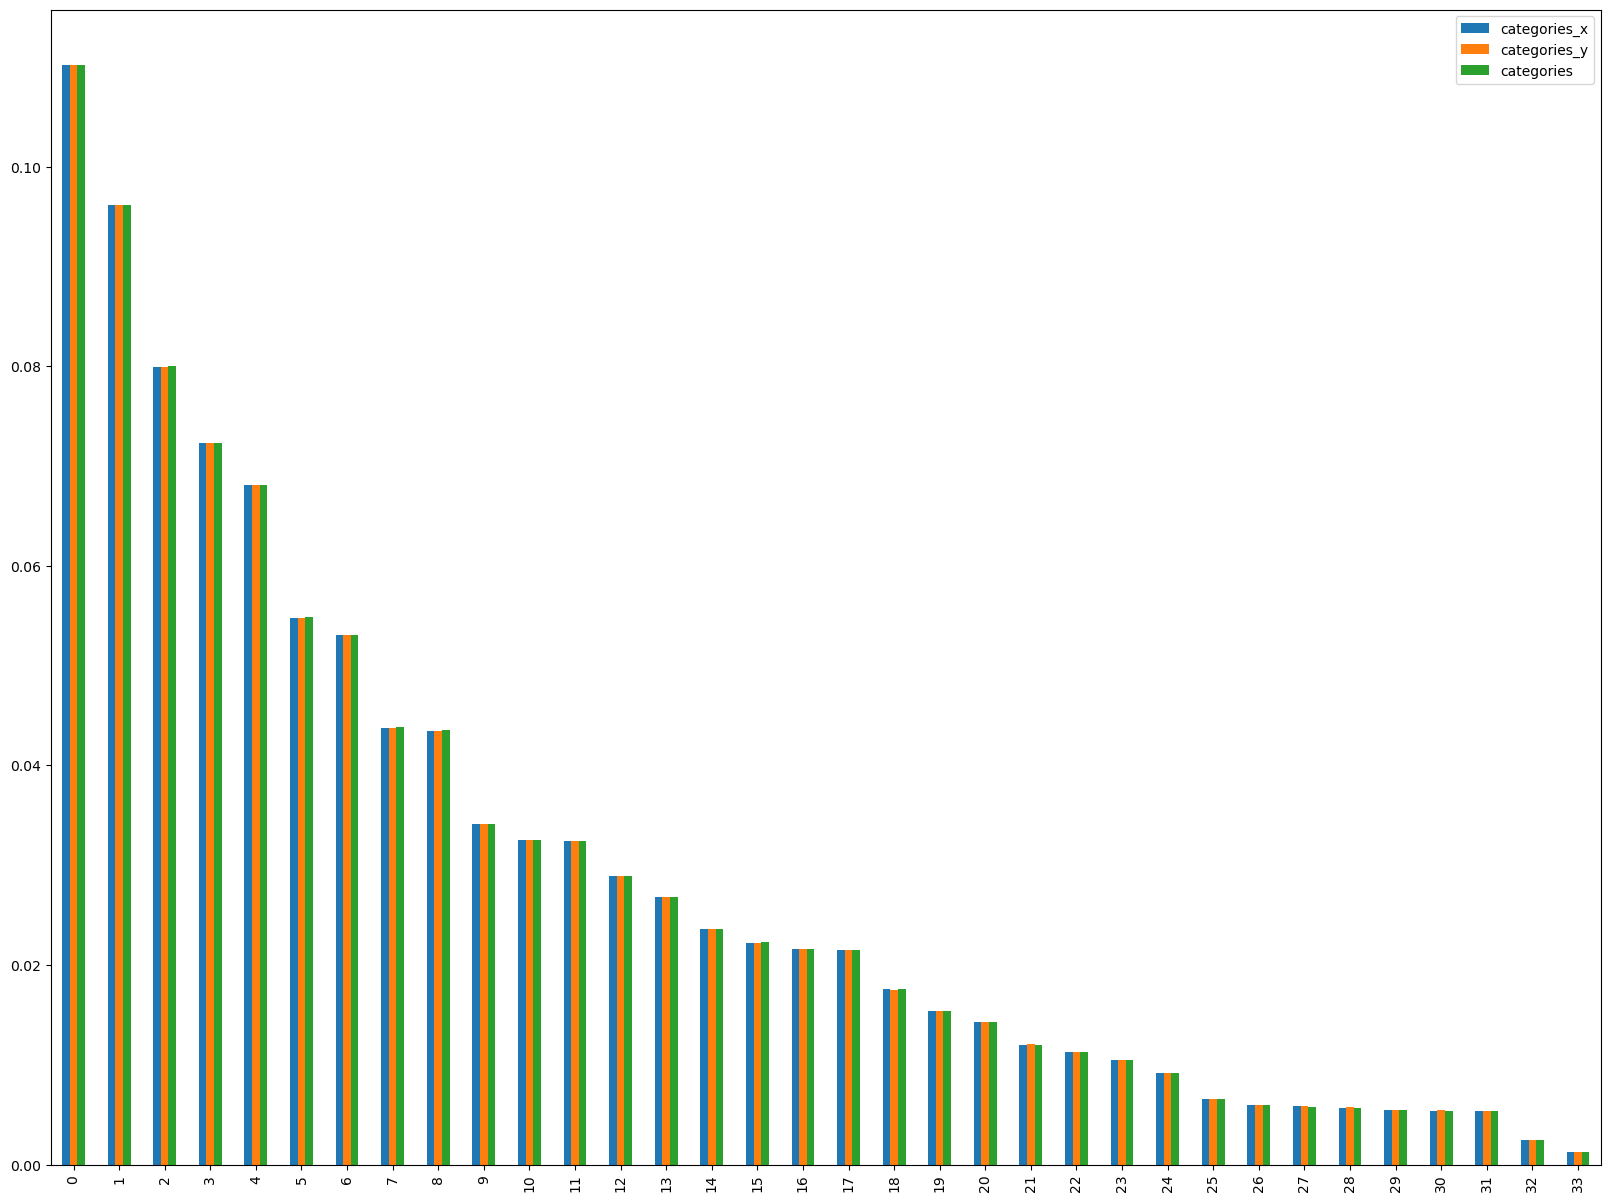

In [5]:
mark_distrib.plot(kind="bar", figsize=(20,15))

In [6]:
X_test.sample(5)

,title,categories,embedding (Bert+MP),embedding (Bert+MP+class-arx),embedding (Bert+MP+class-zbm),embedding (Mathbert+CLS),embedding (Mathbert+MP+class-arx),embedding (Mathbert+MP+class-zbm),embedding (Bert+TSDAE+MP),embedding (Bert+TSDAE+MP+class-arx),...,embedding (SBert+ret_class-arx),embedding (SBert+ret_class-zbm),embedding (Specter 2+MP),embedding (Specter 2.0+MP+class-arx),embedding (Specter 2.0+MP+class-zbm),embedding (Specter 2+MP+class-zbm+anch-arx),embedding (Specter 2+MP+anch-arx+class-arx+class-zbm),embedding (SGPT),embedding (SGPT+class-arx),embedding (SGPT+class-zbm)
19191,On the approximation of quasistatic evolutions...,math.AP,"[-0.21910653, -0.19287445, 0.11787463, 0.03811...","[-0.45510784, -0.78538024, 0.6599348, 0.605243...","[-0.12039922, -0.007023685, 0.7681893, 0.41288...","[-0.042324927, 0.017217536, -0.023088267, -0.0...","[0.32767007, 0.7960855, 0.67989475, 0.37443233...","[0.06339879, 0.16213824, -0.53528035, 1.079850...","[0.048379958, -0.15728548, 0.12102716, 0.28054...","[-0.8277873, -0.7665628, 0.11318273, 0.4272276...",...,"[0.026500424, -0.022275595, 0.021733265, 0.050...","[-0.0070995754, 0.029621368, -0.041579206, 0.0...","[0.24744482, 0.21154933, -0.036178503, 0.25815...","[-0.25596115, 0.73264456, 1.4248266, 0.7619136...","[0.46666265, -0.9688316, -0.9937539, 1.4159244...","[0.26048782, -1.1743175, 0.022246778, 1.447311...","[-0.20605047, -0.6108977, -0.43699583, 1.18413...","[-1.1302484, -1.0015829, 0.29673585, -0.467821...","[-3.5803552, -0.89441675, -0.3384229, -1.31292...","[-0.5579086, -0.028374536, -0.25413445, 0.0164..."
24394,A class of completely monotonic functions invo...,math.CA,"[-0.33295092, -0.3997201, 0.10069262, -0.13652...","[-0.92272824, -0.30563575, 1.1470748, 0.221523...","[0.3346571, 0.5552126, 0.12962727, 0.229847, -...","[-0.014815261, 0.011573736, -0.0060325265, -0....","[0.29031128, -0.30125058, -0.3491604, -0.98395...","[0.79217887, -0.22381547, -0.28725955, -1.4251...","[0.32845032, 0.12888967, -0.3401393, -0.017815...","[-0.47921497, 0.3246944, 0.13770138, -1.116472...",...,"[0.06400154, -0.009649947, 0.079670005, 0.0407...","[0.025746483, 0.029521948, 0.0022922324, -0.04...","[0.35378152, 0.3641282, 0.49570388, -0.6660077...","[-1.413267, 2.6489637, -0.08070599, 0.20078164...","[0.28920883, 0.6545632, -0.47635737, -1.047896...","[-1.1117826, -0.36813155, -0.2623843, -1.95597...","[-1.4119445, 0.019313732, -0.37408838, -1.8044...","[-0.8934777, 1.1502107, -0.5063433, -1.0027852...","[-3.3030477, -1.7963046, 0.106395036, -0.17011...","[-0.47419444, 0.46768275, 0.078796364, -0.4264..."
25129,Distinguished Sets of Semi-simple Lie Algebras,math.RA,"[0.092348404, -0.30991963, 0.09119478, -0.3180...","[0.7140471, -0.27440748, -0.41677684, 0.103180...","[0.016610114, 0.4421684, 0.95188713, 0.0661650...","[-0.03026135, 0.016659137, -0.008353587, -0.00...","[0.11775976, 0.6348374, 0.3942148, 0.9684277, ...","[-0.4222267, -0.41919467, 0.599067, 0.29654238...","[0.16261202, 0.30834514, -0.21540318, -0.14752...","[-0.5226057, -0.34562278, 1.0504494, -0.790773...",...,"[0.029504627, -0.029964581, -0.04708684, 0.014...","[-0.04038832, 0.075334676, -0.023384338, -0.03...","[-0.13552232, 0.6431982, 0.6988493, 0.00696905...","[-1.051306, 2.2839298, -0.23761097, -0.4383252...","[-0.11670835, -0.27449387, 1.9337877, -0.14114...","[-0.6896334, 0.69631094, -0.0075618774, 1.3426...","[0.17835912, 1.0587019, -0.17641525, 1.7597075...","[0.27087042, -0.8157826, 0.0122231, 0.11026111...","[-1.3098572, -1.5419369, 1.0312774, 1.7297571,...","[-0.1705245, -1.5423135, 0.6422456, 0.6597131,..."
18346,Singularities and the wave equation on conic s...,math.AP,"[-0.1846854, -0.19635595, -0.027218496, -0.165...","[-0.45488057, -0.57195723, 1.465222, 0.3224465...","[-0.1282648, 1.0861012, 0.076888174, -0.080547...","[-0.033686813, 0.024384474, -0.011774736, -0.0...","[0.252561, 0.5229734, 0.10258708, -0.1816428, ...","[0.12086923, 0.701446, -0.3669078, -0.348234, ...","[0.06277146, 0.07597589, 

In [7]:
# Prerequisites for the models
bert_base = models.Transformer('bert-base-uncased')
bert_mp = SentenceTransformer(modules=[bert_base, models.Pooling(bert_base.get_word_embedding_dimension())])

mathbert_base = models.Transformer('witiko/mathberta')
mathbert_mp = SentenceTransformer(modules=[mathbert_base, models.Pooling(mathbert_base.get_word_embedding_dimension())])
mathbert_cls = SentenceTransformer(modules=[mathbert_base, models.Pooling(mathbert_base.get_word_embedding_dimension(), pooling_mode="cls")])

bert_mlm_base = models.Transformer("./bert+re-train_mlm_abstracts_arxiv")
bert_mlm_mp = SentenceTransformer(modules=[bert_mlm_base, models.Pooling(bert_mlm_base.get_word_embedding_dimension())])

sbert = SentenceTransformer('all-mpnet-base-v2')
# alternative: sbert = SentenceTransformer('all-distilroberta-v1')

specter2_base = models.Transformer('allenai/specter2_base')

# Definition of models that are evaluated
# combine models into dict
eval_models = {
    "Bert+MP": bert_mp,
    "Bert+MP+class-arx": SentenceTransformer('./bert+mean-pooling+retrain_class_arxiv'),
    "Bert+MP+class-zbm": SentenceTransformer('./bert+mean-pooling+retrain_class_zbmath'),
    
    "Mathbert+CLS": mathbert_cls,
    "Mathbert+MP+class-arx": SentenceTransformer('./mathbert+mean-pooling+retrain_class_arxiv'),
    "Mathbert+MP+class-zbm": SentenceTransformer('./mathbert+mean-pooling+retrain_class_zbmath'),
    
    "Bert+TSDAE+MP": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv'),
    "Bert+TSDAE+MP+class-arx": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv+retrain_class_arxiv'),
    "Bert+TSDAE+MP+class-zbm": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv+retrain_class_zbmath'),
    
    "Bert+MLM+MP": bert_mlm_mp,
    "Bert+MLM+MP+class-arx": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_arxiv'),
    "Bert+MLM+MP+class-zbm": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_zbmath'),
    "Bert+MLM+MP+class-zbm+anch-arx": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_zbmath_anchor_arxiv'),
    "Bert+MLM+MP+class-arx+anch-arx+class-zbm": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_arxiv_anchor_arxiv_class_zbmath'),
    
    "SBert": sbert,
    "SBert+ret_class-arx": SentenceTransformer('./sbert+retrain_class_arxiv'),
    "SBert+ret_class-zbm": SentenceTransformer('./sbert+retrain_class_zbmath'),
    
    "Specter 2+MP": SentenceTransformer(modules=[specter2_base, models.Pooling(specter2_base.get_word_embedding_dimension())]),
    "Specter 2.0+MP+class-arx": SentenceTransformer('./specter2+mp+retrain_class_arxiv'),
    "Specter 2.0+MP+class-zbm": SentenceTransformer('./specter2+mp+retrain_class_zbmath'),
    "Specter 2+MP+class-zbm+anch-arx": SentenceTransformer('./specter2+mp+retrain_class_zbmath_anchor_arxiv'),
    "Specter 2+MP+anch-arx+class-arx+class-zbm": SentenceTransformer('./specter2+mp+retrain_anchor_arxiv_class_arxiv_class_zbmath'),
    
    "SGPT": SentenceTransformer('Muennighoff/SGPT-125M-weightedmean-nli-bitfit'),
    "SGPT+class-arx": SentenceTransformer('./gpt+retrain_class_arxiv'),
    "SGPT+class-zbm": SentenceTransformer('./gpt+retrain_class_zbmath'),
}

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at witiko/mathberta were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_h

In [8]:
def suggest(eval_models, corpus, queries, device="cuda:0", msc_col="MSC", **search_args):
    msc_sug = pd.DataFrame()
    with tqdm(total=len(eval_models), desc="Models") as pb:
        for n,m in eval_models.items():
            c = torch.stack([torch.tensor(v) for v in corpus["{} ({})".format("embedding", n)].values])
            c.to(device)
            c = stu.normalize_embeddings(c)
            
            q = torch.stack([torch.tensor(v) for v in queries["{} ({})".format("embedding", n)].values])
            q.to(device)
            q = stu.normalize_embeddings(q)
            
            idxs = pd.Series([[r["corpus_id"] for r in res] for res in stu.semantic_search(q, c, score_function=stu.dot_score, **search_args)])
            msc_sug["{} ({})".format(msc_col, n)] = idxs.map(lambda e: corpus.loc[e][msc_col].values)

            pb.update()
    msc_sug.index = queries.index
    return msc_sug

In [11]:
%%time
X_test = X_test.join(suggest(eval_models, X_train, X_test, device="cuda:0", msc_col="categories", top_k=200, query_chunk_size=5000, corpus_chunk_size=500000))

Models:   0%|          | 0/25 [00:00<?, ?it/s]

CPU times: user 48min 40s, sys: 17min 30s, total: 1h 6min 11s
Wall time: 9min 45s


In [12]:
%%time
X_eval = X_eval.join(suggest(eval_models, X_train, X_eval, device="cuda:0", msc_col="categories", top_k=200, query_chunk_size=10000, corpus_chunk_size=500000))

Models:   0%|          | 0/25 [00:00<?, ?it/s]

CPU times: user 46min 9s, sys: 18min 11s, total: 1h 4min 20s
Wall time: 9min 40s


In [14]:
X_test.to_pickle("arxiv-title-title-200-recommendations-single-class-multi-test.pkl")
X_eval.to_pickle("arxiv-title-title-200-recommendations-single-class-multi-eval.pkl")